## Imports

In [19]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from cleanlab import Datalab
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# gets rid of irritating warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Download and load the data. Perform the initial exploration and cleaning

In [20]:
dataset_dict = load_dataset("PolyAI/banking77", trust_remote_code=True)
labels_feature_class = dataset_dict["train"].features["label"]
df_train = dataset_dict["train"].to_pandas()
df_test = dataset_dict["test"].to_pandas()

In [21]:
# Checking shapes
df_train.shape, df_test.shape

((10003, 2), (3080, 2))

In [22]:
# Displaying data
df_train.head(5)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [23]:
df_test.head(5)

,text,label
0,How do I locate my card?,11
1,"I still have not received my new card, I order...",11
2,I ordered a card but it has not arrived. Help ...,11
3,Is there a way to know when my card will arrive?,11
4,My card has not arrived yet.,11


In [24]:
# Checking column types
# E.g label type could be change to smaller int to save memory as label range is 0-76
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3080 non-null   object
 1   label   3080 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.3+ KB


In [26]:
# There are no obvious missing values
df_train.isna().sum(), df_test.isna().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [27]:
# There are no obsious duplicates in text column. Rest will be checked later with CleanLab
df_train["text"].nunique(), df_test["text"].nunique()

(10003, 3080)

In [28]:
df_deduplicated = df_train.copy()
df_deduplicated["text_lower"] = df_deduplicated["text"].str.lower()
df_deduplicated = df_deduplicated.drop_duplicates(subset="text_lower")
df_deduplicated = df_deduplicated.drop(columns="text_lower")
df_deduplicated = df_deduplicated.reset_index(drop=True)
df_deduplicated.shape
# Also checking if there are no case-insensitive duplicates because pandas is case-sensitive about finding duplicates.
# In our example, there are no case-insensitive duplicates as well.

(10003, 2)

In [29]:
# Checking unique labels
train_unique_labels = df_train["label"].nunique()
test_unique_labels = df_test["label"].nunique()
print(f"Number of unique labels in training set: {train_unique_labels}")
print(f"Number of unique labels in test set: {test_unique_labels}")

Number of unique labels in training set: 77
Number of unique labels in test set: 77


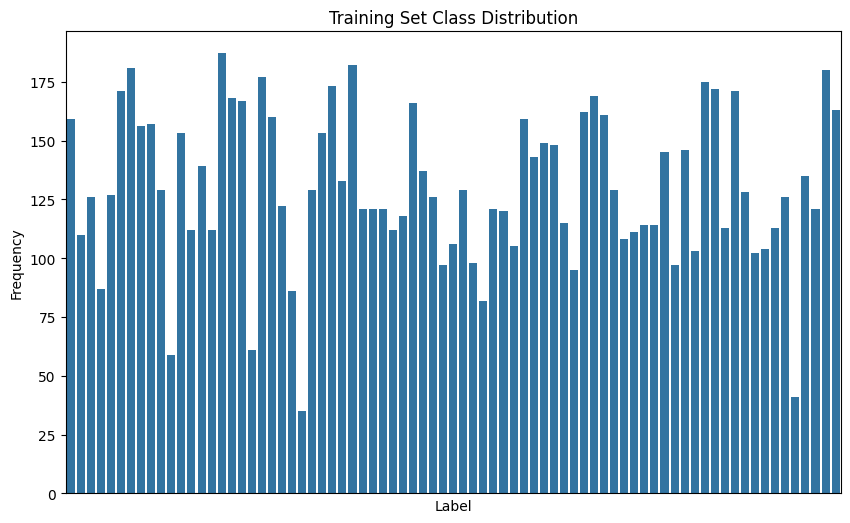

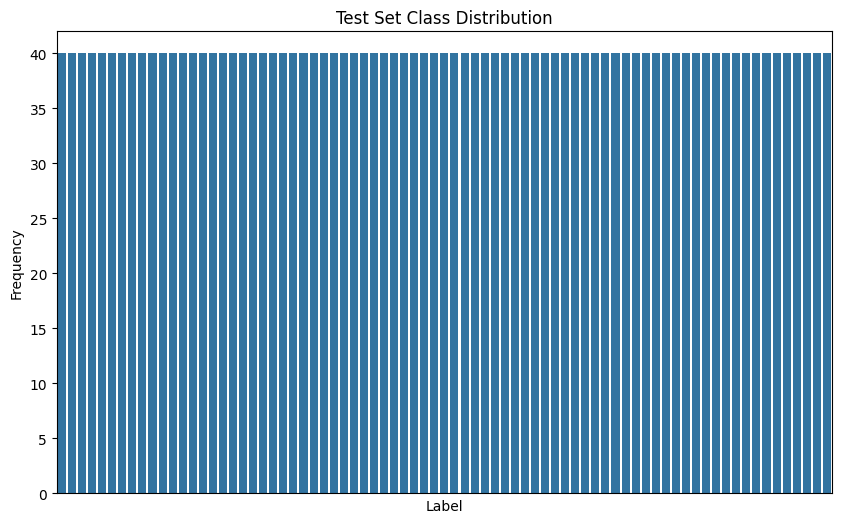

In [30]:
def plot_class_distribution(df, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(x="label", data=df)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Frequency")
    plt.xticks([])
    plt.show()


plot_class_distribution(df_train, "Training Set Class Distribution")
plot_class_distribution(df_test, "Test Set Class Distribution")
# I removed labels values from x axis for better visibility
# Test set seems to have ideal balance between classes, while training set has some minor variations
# Maybe better option to split would be stratified sampling, but I will just use given by author split

In [31]:
def plot_text_length_distribution(df, title):
    df_to_plot = df.copy()
    df_to_plot["text_length"] = df_to_plot["text"].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df_to_plot["text_length"], bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()
    mix_txt_length = df_to_plot["text_length"].min()
    max_txt_length = df_to_plot["text_length"].max()
    mean_txt_length = df_to_plot["text_length"].mean()
    median_txt_length = df_to_plot["text_length"].median()
    std_txt_length = df_to_plot["text_length"].std()
    print(
        f"Text Length - min: {mix_txt_length}, max: {max_txt_length}, mean: {mean_txt_length:.2f},"
        f" median: {median_txt_length}, std: {std_txt_length:.2f}"
    )

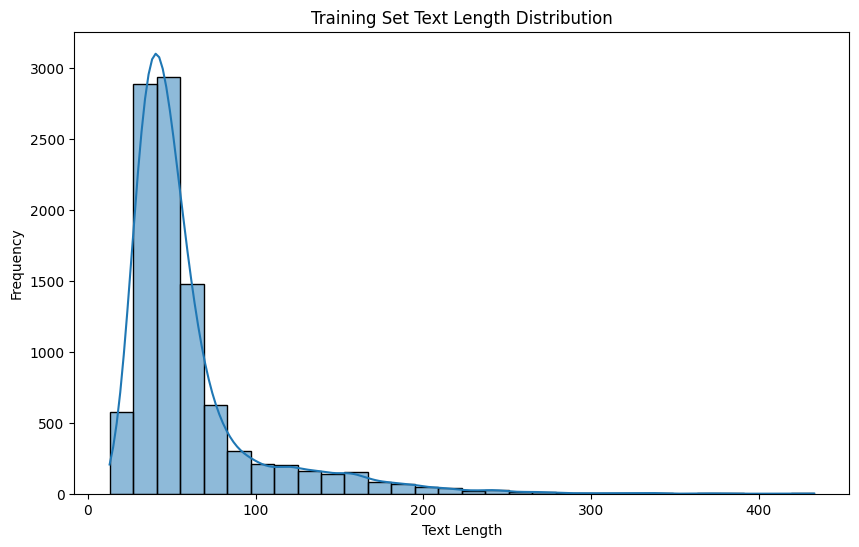

Text Length - min: 13, max: 433, mean: 59.47, median: 47.0, std: 40.87


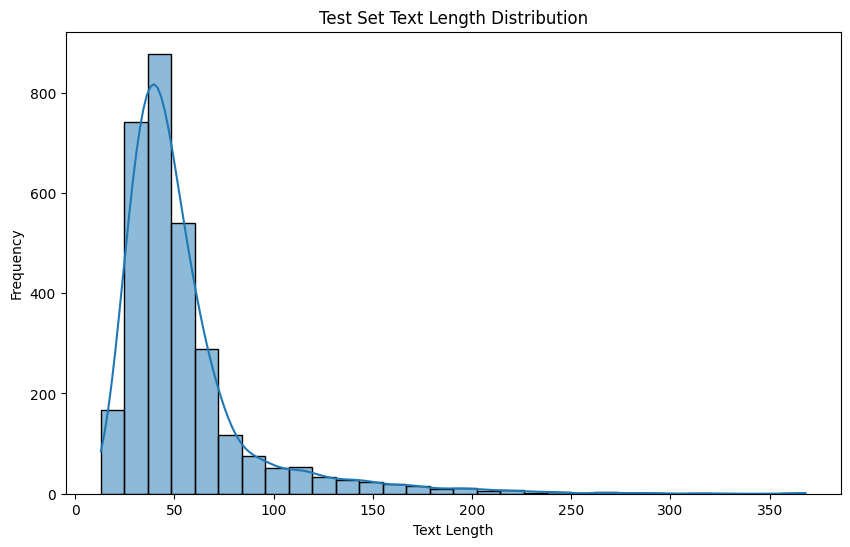

Text Length - min: 13, max: 368, mean: 54.23, median: 45.0, std: 34.66


In [32]:
plot_text_length_distribution(df_train, "Training Set Text Length Distribution")
plot_text_length_distribution(df_test, "Test Set Text Length Distribution")

Text lenghts are similar across train and test split

## Use CleanLab to detect and fix data quality issues

In [33]:
def get_initial_model_data(
    texts: np.ndarray, labels: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    classifier = LogisticRegression(max_iter=1000, class_weight="balanced")
    classifier.fit(embeddings, labels)
    pred_probs = cross_val_predict(
        classifier, embeddings, labels, cv=5, method="predict_proba", n_jobs=-1
    )
    return embeddings, pred_probs


texts = df_train["text"].values
labels = df_train["label"].values

In [34]:
embeddings, pred_probs = get_initial_model_data(texts, labels)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [35]:
data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

In [36]:
# duplicated
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")
duplicate_issues

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
1710,True,0.000000,[1724],0.000000
1290,True,0.000000,[1246],0.000000
1246,True,0.000000,[1290],0.000000
4594,True,0.000000,[4595],0.000000
4595,True,0.000000,[4594],0.000000
...,...,...,...,...
4403,True,0.121103,[4437],0.011252
4437,True,0.121103,[4403],0.011252
2309,True,0.121142,[2237],0.011256
2237,True,0.121142,[2309],0.011256


In [37]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates: ['I put the wrong pin too many times and now it is blocked. Can you help me unblock it?']

Text: 
I can't seem to be able to use my card



	Duplicates: ["I can't seem to be able to use my card"]

Text: I can't seem to be able to use my card
	Duplicates: ["\nI can't seem to be able to use my card\n\n\n"]

Text: Where can I withdraw money from?
	Duplicates: ['\nWhere can I withdraw money from?']

Text: 
Where can I withdraw money from?
	Duplicates: ['Where can I withdraw money from?']

Text: How can I reset my passcode?
	Duplicates: ['How can i reset my passcode ?' 'How do I reset my passcode?']

Text: How can i reset my passcode ?
	Duplicates: ['How can I reset my passcode?' 'How do I reset my passcode?']

Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates: ['\nI put the wrong pin too many times and now it is blocked. Can you hel

In [38]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: What should I do if I can't prove my identity.
	Duplicates: ["What do I do if I can't prove my identity?"]

Text: How can I receive a virtual card?
	Duplicates: ['How do I receive a virtual card?']

Text: How do I receive a virtual card?
	Duplicates: ['How can I receive a virtual card?']

Text: Can you please tell me why my transfer failed?
	Duplicates: ['Can you please explain why my transfer failed?']

Text: Can you please explain why my transfer failed?
	Duplicates: ['Can you please tell me why my transfer failed?']

Text: Is there a limit to a disposable virtual card?
	Duplicates: ['Is there a limit to using a disposable virtual card?']

Text: Is there a limit to using a disposable virtual card?
	Duplicates: ['Is there a limit to a disposable virtual card?']

Text: Can I top up any amount?
	Duplicates: ['Can I top-up any amount?']

Text: Can I top-up any amount?
	Duplicates: ['Can I top up any amount?']

Text: How long will a transfer from the US take?
	Duplicates: ['How long

Detected duplication seems relevant because there are examples of almost identical sentences that differ only in minor aspects, such as whitespace between words or punctuation, especially for the most confident scores. For the least confident scores, there are examples of sentences with the same meaning but minimal changes in structure, such as `“Can you please explain why my transfer failed?”` and `“Can you please tell me why my transfer failed?”`.

I believe it’s worth removing them, as they do not introduce any valuable information and mostly add noise. The percentage of duplicates is 350 / 10,003 (~3.5%), so I think we can simply remove them. However, in scenarios with a much higher number of duplicates, we should spend more time considering how to handle them properly.

In [39]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(
    top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred
):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()

Top 10 label issues
y_true 47, y_pred 62, text: i put money on my card and i dont see it on the balance

y_true 29, y_pred 40, text: i am not a premium customer but i want a virtual card, how do i get it

y_true 26, y_pred 14, text: Is my card actually working? It's the first time I tried using it

y_true 65, y_pred 62, text: How do I top up?

y_true 59, y_pred 25, text: My credit card transaction was declined for a loan payment.  Can you tell me why?

y_true 48, y_pred 5, text: I have not seen any changes in my account balance(s) after making a transfer.

y_true 41, y_pred 11, text: Can you tell me the status of my new card?

y_true 67, y_pred 5, text: I just did a transfer, but don't see the money in my account. What's up?

y_true 26, y_pred 49, text: my card was frozen due to putting in the wrong pin too much.  how many tries do i have

y_true 22, y_pred 41, text: How do I order a replacement for stolen card?



Label issues also seem to be relevant, and the proposed label fits the label description better. However, it’s not as easy as it was in the laboratory when we only had two labels, because now there are 76. Some labels are similar to each other, and with ambiguous texts it can be difficult to classify them correctly.

In [40]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score")
top_outlier_issues_score = outlier_issues.head(15)["outlier_score"]
top_outlier_issues_idxs = outlier_issues.head(15).index
top_oulier_issues_texts = texts[top_outlier_issues_idxs]


print("Top 15 outlier issues")
for score, text in zip(top_outlier_issues_score, top_oulier_issues_texts):
    print(f"outlier_score {score}, text: {text}", end="\n\n")

Top 15 outlier issues
outlier_score 0.005061218049377203, text: WHAT IS THE ATMOSPHERE OF IT

outlier_score 0.0063031562604010105, text: what is the word?

outlier_score 0.007869746536016464, text: What is this witdrawal

outlier_score 0.00793471559882164, text: what is the matter?

outlier_score 0.008736877702176571, text: WHAT IS THE SOLUTION OF THIS PROBLEM

outlier_score 0.010668120346963406, text: I prefer Mastecard.

outlier_score 0.016369424760341644, text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?

outlier_score 0.01666278764605522, text: WHAT IS THE MAIN REASON OF THIS PROBLEM

outlier_score 0.016842763870954514, text: WHAT IS THE REASON FOR THAT

outlier_score 0.018882911652326584, text: why was i chargged

outlier_score 0.02010991983115673, text: I have a trasnger that is pending and wondered about it.

outlier_score 0.020167753100395203, text: As far as courtries go which

Outliers seem to include ambiguous texts such as `“what is the word?”` or `“WHAT IS THE REASON FOR THAT”`. This ambiguity can be challenging for the classifier, and I would also remove these texts. Overall, I agree with the results in the paper claiming that this dataset has label quality issues, and in my opinion it’s worth fixing them. I showed some examples that definitely introduce noise into the data rather than relevant information.

In [41]:
# fixing label issues
idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]
df_train.loc[idxs, "label"] = pred_labels

In [42]:
# Fixing duplicate and outlier issues
dup_idxs = duplicate_issues.index.tolist()
outlier_idxs = outlier_issues.index.tolist()
all_idxs_to_remove = set(dup_idxs + outlier_idxs)
df_train = df_train.drop(index=all_idxs_to_remove).reset_index(drop=True)
df_train.shape

(9522, 2)

## Train a small text classifier


In [43]:
# prepare data

# 80% - 20% train val split
val_size = int(0.2 * len(df_train))

df_train, df_valid = train_test_split(
    df_train, test_size=val_size, random_state=0, stratify=df_train["label"]
)

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [44]:
datasets_dict["train"].data

InMemoryTable
text: string
label: int64
__index_level_0__: int64
----
text: [["Where do I go to terminate my account?","Why hasn't my son received the transfer I sent to him earlier?","I think someone may have cloned my card or something.  My card isn't lost but I just saw a charge of $500 cash withdraw.  Can you help me?","There is random cash in my account.","What is the time frame that transfers normally take from a UK account? I just completed a transfer and nothing shows up. I need to know if everything is alright.",...,"I tried activation my card and it didn't employment","Why can't I use my beneficiary?","Please help!  I was mugged and everything stolen.  What do I do to stop them from accessing my account?","And do you have virtual cards instead of physical ones?","I'd like to open an account for my children. How can I do that?"]]
label: [[55,66,20,20,5,...,0,7,42,40,1]]
__index_level_0__: [[5893,2644,8415,8519,8278,...,8769,6748,5012,2905,1533]]

In [45]:
# tokenization
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7618 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
import os
import random

from sklearn.metrics import matthews_corrcoef, f1_score
import numpy as np
from torch.nn.functional import softmax
from transformers import (
    AutoModelForSequenceClassification,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)
import evaluate


# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=len(np.unique(datasets_tokenized["train"]["label"])),
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


# Freeze all weights
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier and pre_classifier (they MUST learn)
for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.pre_classifier.parameters():
    param.requires_grad = True

# Unfreeze last 3 transformer layers
for layer in model.distilbert.transformer.layer[-3:]:
    for param in layer.parameters():
        param.requires_grad = True


# calculate metrics based on huggingface documentation
# I'm using macro f1 score because default is for binary classification
metric = evaluate.load("f1", average="macro")


def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")


# calculate f1 score manually
# def compute_metrics(eval_pred: EvalPrediction) -> dict:
#     y_true = eval_pred.label_ids.ravel()
#     logits = torch.from_numpy(eval_pred.predictions)
#     y_pred_proba = softmax(logits, dim=1).numpy()
#     y_pred = np.argmax(y_pred_proba, axis=1)
#     f1 = f1_score(y_true, y_pred, average="macro")
#     return {"F1": f1}

training_args = TrainingArguments(
    output_dir="finetuned_model",
    learning_rate=3e-4,
    optim="adamw_torch",
    # batch size
    per_device_train_batch_size=20,
    per_device_eval_batch_size=40,
    # gradient accumulation steps - its accumulate gradients over 2 steps to simulate larger batch size
    gradient_accumulation_steps=2,
    # learning rate warmup ratio
    warmup_ratio=0.1,
    # CLip gradient for stability
    max_grad_norm=1.0,
    # Regularizartion L2 for adamw optimizer
    weight_decay=0.01,
    num_train_epochs=10,
    eval_strategy="steps",
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    # comment as mps doesnt support fp16
    # fp16=True,  # comment this out if you have unsupported hardware
    # I've got problem with running it in mac m4 pro, but I found solution:
    # https://github.com/huggingface/accelerate/pull/3736
    # This is a common problem as I found in internet, theoretically accelerate library in version 1.11: https://github.com/huggingface/accelerate/releases
    # should handled with fp16 also, but in uv.lock there is 1.6 version installed and I didnt' want to
    # reinstall it at this stage, and as bf16 works fine for me, so I used it
    fp16=False,
    bf16=True,
    # Workers - adjusted for my local runtime
    dataloader_num_workers=4,
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/dawidwozniak/.local/share/uv/python/cpython-3.11.4-macos-aarch64-none/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dawidwozniak/.local/share/uv/python/cpython-3.11.4-macos-aarch64-none/lib/python3.11/multiprocessing/spawn.py", line 128, in _main
    preparation_data = reduction.pickle.load(from_parent)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


Step,Training Loss,Validation Loss,F1
200,No log,2.334625,0.497896
400,No log,0.526704,0.860193
600,2.116400,0.387215,0.906708
800,2.116400,0.332818,0.914628
1000,0.184100,0.323729,0.918553
1200,0.184100,0.304357,0.923122
1400,0.184100,0.305785,0.924789
1600,0.021000,0.301203,0.927512
1800,0.021000,0.300403,0.926282


TrainOutput(global_step=1900, training_loss=0.6128966080515008, metrics={'train_runtime': 1114.0632, 'train_samples_per_second': 68.38, 'train_steps_per_second': 1.705, 'total_flos': 1818460247751948.0, 'train_loss': 0.6128966080515008, 'epoch': 9.950131233595801})

In [48]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score


pred_output = trainer.predict(datasets_tokenized["test"])
logits = torch.from_numpy(pred_output.predictions)
y_pred_proba = softmax(logits, dim=1).numpy()
y_pred = np.argmax(y_pred_proba, axis=1)
y_test = datasets_tokenized["test"]["label"]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score (macro): {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr'):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

print("F1-score calculated for each class:\n\n")
f1_score_results = f1_score(y_test, y_pred, average=None)
for idx, score in enumerate(f1_score_results):
    print(f"Class {idx} - {labels_feature_class.int2str(idx)}: F1-score: {score:.2%}")

Accuracy: 92.50%
Precision (macro): 92.88%
Recall (macro): 92.50%
F1-score (macro): 92.50%
AUROC: 99.86%
MCC: 92.41%
F1-score calculated for each class:


Class 0 - activate_my_card: F1-score: 96.30%
Class 1 - age_limit: F1-score: 97.56%
Class 2 - apple_pay_or_google_pay: F1-score: 100.00%
Class 3 - atm_support: F1-score: 98.77%
Class 4 - automatic_top_up: F1-score: 94.87%
Class 5 - balance_not_updated_after_bank_transfer: F1-score: 80.00%
Class 6 - balance_not_updated_after_cheque_or_cash_deposit: F1-score: 96.30%
Class 7 - beneficiary_not_allowed: F1-score: 92.11%
Class 8 - cancel_transfer: F1-score: 97.50%
Class 9 - card_about_to_expire: F1-score: 100.00%
Class 10 - card_acceptance: F1-score: 91.14%
Class 11 - card_arrival: F1-score: 87.80%
Class 12 - card_delivery_estimate: F1-score: 90.00%
Class 13 - card_linking: F1-score: 97.44%
Class 14 - card_not_working: F1-score: 91.36%
Class 15 - card_payment_fee_charged: F1-score: 90.24%
Class 16 - card_payment_not_recognised: F1-score: 88

It seems that I’ve achieved almost the same F1-score as reported in the paper — they had 0.878 for the original dataset and 0.92 for the trimmed dataset (after applying a data-centric AI approach), while I obtained 0.925. However, there are some methodological differences, because they calculated the F1-score using cross-validation, whereas I used a test dataset. They achieved their results with a LightGBM classifier, while I used a transformer model with the `distilbert/distilbert-base-uncased` encoder.

In my opinion, these are strong results, especially considering that we are dealing with 77 classes, which is not a trivial scenario, and the data-centric AI approach really improved performance. In terms of differences between classes, the lowest score was 80% for `Class 5 - balance_not_updated_after_bank_transfer`, and the highest was 100% for `Class 2 - apple_pay_or_google_pay`.

## Use Giskard for behavioral testing

In [50]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model,
    tokenizer=tokenizer,
    top_k=None,
    # comment as model was loaded with acclerate with device map auto and returns error
    # device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist(), top_k=None)
    # parsing huggingface output to giskard expected format
    # hugginface return per row, list of dicts with label and score:
    # {'label': 'LABEL_6', 'score': 0.987654321}
    # gliskard expect per row, list of probabilities in order of labels
    # Second approach could be resign from huggingface pipeline
    # and manually tokenize examples, pass them to model, get logits and apply softmax on them

    predictions = [
        [
            item["score"]
            for item in sorted(
                row,
                key=lambda x: int(x["label"].split("_")[-1]),  # Parsing "LABEL_6" -> 6
            )
        ]
        for row in pred_output
    ]

    return np.array(predictions)


giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=np.unique(datasets_tokenized["train"]["label"]).tolist(),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use mps


2025-11-23 13:52:07,870 pid:18375 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-23 13:52:07,873 pid:18375 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-23 13:52:07,886 pid:18375 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 13:52:08,380 pid:18375 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.501288
2025-11-23 13:52:08,386 pid:18375 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 13:52:08,397 pid:18375 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.015492
2025-11-23 13:52:08,400 pid:18375 MainThread giskard.datasets.base 

<iframe id="scan-13605210640" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

Gliskard shows that my classifier have 2 major and 2 medium issues so it's not a lot of problems. 
###  1 major problem:
![major_problem_1](assets/gliskard_major_1.png)

It's interesting, by perturbate country name with country with poor economic situation, my classfier change prediction in 18% cases

### 2 major problem:
![major_problem_2](assets/gliskard_major_2.png)

It's also interesting, by adding typos perturbation to input text like `have` -> `hwve` classifier also change prediction in 26% cases

### Medium problems:
![medium_problems](assets/gliskard_medium.png)

It's less important issues but worth to know that, model behvaiour is slightly different for text with length between 48.5 and 51.5 and for text that contains word `money`

## Use Captum for local explainability

In [51]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)
        y_pred_proba_cpu = y_pred_proba.float().cpu().numpy()
        y_pred = np.argmax(y_pred_proba_cpu, axis=1)

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=torch.max(y_pred_proba).item(),
        pred_class=y_pred,
        true_class=y_true,
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

In [64]:
# activate_my_card label
first_3_activate_my_card = df_test[df_test["label"] == 0].head(3)
# visa_or_mastercard label
first_3_visa_or_mastercard = df_test[df_test["label"] == 73].head(5)

In [53]:
print("Testing first 3 activate_my_card samples:")
for _, row in first_3_activate_my_card.iterrows():
    explain_text(trained_model, row["text"], row["label"])

Testing first 3 activate_my_card samples:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,[0] (1.00),1,1.47,could you please activate my card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,[0] (1.00),1,0.18,i need to activate my card can you do that now ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,[0] (1.00),1,-1.23,what do i need to do to activate my new card ?


For the `activate_my_card label`, the explanations are reasonable, as we have highlighted words like please, activate, and card. However, there is some inconsistency, because in the last example the word activate has a negative impact, whereas I believe it should have a positive impact, just like in the first and second examples.

In [65]:
print("Testing first 3 visa_or_mastercard samples:")
for _, row in first_3_visa_or_mastercard.iterrows():
    explain_text(trained_model, row["text"], row["label"])

Testing first 3 visa_or_mastercard samples:


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
73,[73] (1.00),1,-0.74,i like to master ##card rather than visa .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
73,[73] (1.00),1,-0.29,do i qualify for a visa card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
73,[73] (1.00),1,-0.03,how do i get a visa card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
73,[73] (1.00),1,0.51,do you guys accept visa or master ##card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
73,[73] (1.00),1,-0.21,are both visa and master ##card accepted ?


For the `visa_or_mastercard` label, when only visa appears in the sentence, it has a strong positive impact. When both visa and mastercard appear in the sentence, visa receives a much weaker positive impact, or even both visa and mastercard have a negative impact.